# 高级 RAG 评估

本手册介绍了在高级 RAG 上运行 eval(s) 的过程。

这对于确定适合您应用程序的最佳 RAG 方法非常有用。

In [ ]:
# 安装最新版本的 langchain, openai, chromadb, langchain-experimental
! pip install -U langchain openai chromadb langchain-experimental

In [ ]:
# 由于较新版本中存在持久性错误，将版本锁定为0.10.19
! pip install "unstructured[all-docs]==0.10.19" pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch

# 安装所需的软件包
# - "unstructured[all-docs]==0.10.19"：安装名为unstructured的软件包，版本为0.10.19，并包括所有文档
# - pillow：Python图像处理库
# - pydantic：用于数据验证和设置的Python库
# - lxml：用于处理XML和HTML的Python库
# - matplotlib：用于绘制图表和可视化数据的Python库
# - tiktoken：用于分词和标记化的Python库
# - open_clip_torch：用于训练和使用OpenAI的CLIP模型的Python库
# - torch：用于深度学习的Python库

## 数据加载

让我们来看一个[示例白皮书](https://sgp.fas.org/crs/misc/IF10244.pdf)，其中包含有关美国森林火灾的表格、文本和图片的混合内容。

### 选项 1：加载文本

In [1]:
# 路径
path = "/Users/rlm/Desktop/cpi/"

# 加载
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(path + "cpi.pdf")
pdf_pages = loader.load()

# 分割
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
all_splits_pypdf = text_splitter.split_documents(pdf_pages)
all_splits_pypdf_texts = [d.page_content for d in all_splits_pypdf]

### 选项2：加载文本、表格和图片



In [2]:

from unstructured.partition.pdf import partition_pdf  # 导入 partition_pdf 函数

# 提取图片、表格和分块文本
raw_pdf_elements = partition_pdf(  # 调用 partition_pdf 函数
    filename=path + "cpi.pdf",  # 传入文件名参数
    extract_images_in_pdf=True,  # 提取 PDF 中的图片
    infer_table_structure=True,  # 推断表格结构
    chunking_strategy="by_title",  # 按标题分块策略
    max_characters=4000,  # 最大字符数
    new_after_n_chars=3800,  # 在第 n 个字符后换行
    combine_text_under_n_chars=2000,  # 在少于 n 个字符的文本下合并
    image_output_dir_path=path,  # 图片输出目录路径
)

# 按类型分类
tables = []  # 表格列表
texts = []  # 文本列表
for element in raw_pdf_elements:  # 遍历 raw_pdf_elements
    if "unstructured.documents.elements.Table" in str(type(element)):  # 如果是表格类型
        tables.append(str(element))  # 将元素转换为字符串并添加到表格列表
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):  # 如果是复合元素类型
        texts.append(str(element))  # 将元素转换为字符串并添加到文本列表


## 存储

### 选项 1：嵌入，存储文本块

In [3]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

baseline = Chroma.from_texts(
    texts=all_splits_pypdf_texts,
    collection_name="baseline",
    embedding=OpenAIEmbeddings(),
)
retriever_baseline = baseline.as_retriever()

### 选项2：多向量检索器

#### 文本摘要

In [4]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# 提示
prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
These summaries will be embedded and used to retrieve the raw text or table elements. \
Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# 文本摘要链
model = ChatOpenAI(temperature=0, model="gpt-4")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

# 应用于文本
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

# 应用于表格
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

#### 图像摘要

In [9]:
# 图像摘要链
import base64
import io
import os
from io import BytesIO

from langchain_core.messages import HumanMessage
from PIL import Image

# 定义函数，用于将图像编码为base64字符串
def encode_image(image_path):
    """获取base64字符串"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# 定义函数，用于图像摘要
def image_summarize(img_base64, prompt):
    """图像摘要"""
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content

# 存储base64编码的图像
img_base64_list = []

# 存储图像摘要
image_summaries = []

# 提示信息
prompt = """You are an assistant tasked with summarizing images for retrieval. \
These summaries will be embedded and used to retrieve the raw image. \
Give a concise summary of the image that is well optimized for retrieval."""

# 对图像应用操作
for img_file in sorted(os.listdir(path)):
    if img_file.endswith(".jpg"):
        img_path = os.path.join(path, img_file)
        base64_image = encode_image(img_path)
        img_base64_list.append(base64_image)
        image_summaries.append(image_summarize(base64_image, prompt))

### 选项2a：多向量检索器，带原始图像

* 将图像返回给LLM进行答案合成

In [11]:

import uuid  # 导入uuid模块，用于生成唯一标识符
from base64 import b64decode  # 从base64模块中导入b64decode函数

from langchain.retrievers.multi_vector import MultiVectorRetriever  # 从langchain.retrievers.multi_vector模块中导入MultiVectorRetriever类
from langchain.storage import InMemoryStore  # 从langchain.storage模块中导入InMemoryStore类
from langchain_core.documents import Document  # 从langchain_core.documents模块中导入Document类


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    # 初始化存储层
    store = InMemoryStore()
    id_key = "doc_id"  # 设置文档ID的键名为"doc_id"

    # 创建多向量检索器
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,  # 向量存储
        docstore=store,  # 文档存储
        id_key=id_key,  # ID键名
    )

    # 辅助函数，用于向向量存储和文档存储中添加文档
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]  # 生成与文档内容数量相等的唯一标识符列表
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})  # 创建包含摘要内容和元数据的文档对象
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)  # 向向量存储中添加摘要文档
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))  # 向文档存储中添加文档内容

    # 添加文本、表格和图片
    # 在添加之前检查文本摘要是否为空
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # 在添加之前检查表格摘要是否为空
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # 在添加之前检查图片摘要是否为空
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever  # 返回创建的多向量检索器


# 用于索引摘要的向量存储
multi_vector_img = Chroma(
    collection_name="multi_vector_img", embedding_function=OpenAIEmbeddings()
)

# 创建检索器
retriever_multi_vector_img = create_multi_vector_retriever(
    multi_vector_img,  # 向量存储
    text_summaries,  # 文本摘要
    texts,  # 文本内容
    table_summaries,  # 表格摘要
    tables,  # 表格内容
    image_summaries,  # 图片摘要
    img_base64_list,  # 图片的base64编码列表
)


In [32]:
# 在检索上进行测试

# 设置查询语句
query = "CPI中有多少百分比用于住房，与医疗保健、服装和其他商品和服务的百分比相比如何？"
# 设置图片后缀
suffix_for_images = " 包括任何饼图、图表或表格。"
# 调用检索器的多向量图像检索方法，并传入查询语句和图片后缀
docs = retriever_multi_vector_img.invoke(query + suffix_for_images)


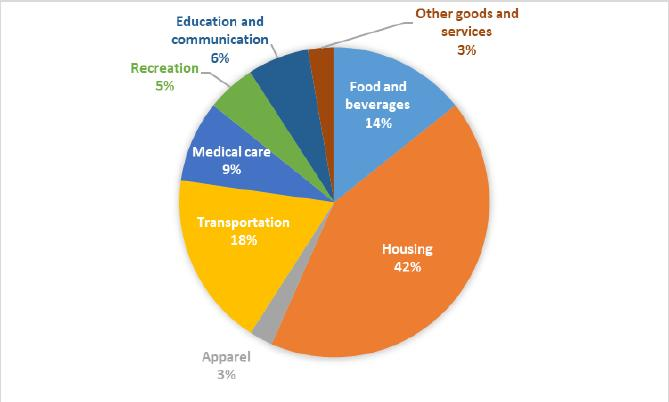

In [19]:
from IPython.display import HTML, display

def plt_img_base64(img_base64):
    # 创建一个包含base64字符串作为源的HTML img标签
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # 通过渲染HTML来显示图像
    display(HTML(image_html))

plt_img_base64(docs[1])

### 选项2b：带有图像摘要的多向量检索器

* 将图像的文本摘要返回给LLM以进行答案合成

In [20]:
# 使用的向量存储库来索引摘要
multi_vector_text = Chroma(
    collection_name="multi_vector_text", embedding_function=OpenAIEmbeddings()
)

# 创建检索器
retriever_multi_vector_img_summary = create_multi_vector_retriever(
    multi_vector_text,
    text_summaries,  # 文本摘要
    texts,  # 文本
    table_summaries,  # 表格摘要
    tables,  # 表格
    image_summaries,  # 图像摘要
    image_summaries,  # 图像
)

### 选项3：多模态嵌入



In [22]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings  # 导入OpenCLIPEmbeddings类

# 创建具有多模态嵌入的Chroma对象
multimodal_embd = Chroma(
    collection_name="multimodal_embd", embedding_function=OpenCLIPEmbeddings()  # 使用OpenCLIPEmbeddings函数创建多模态嵌入
)

# 获取图像URI
image_uris = sorted(
    [
        os.path.join(path, image_name)  # 将图像名称与路径连接起来
        for image_name in os.listdir(path)  # 遍历路径下的所有文件名
        if image_name.endswith(".jpg")  # 选择以.jpg结尾的文件
    ]
)

# 添加图像和文档
if image_uris:  # 如果存在图像URI
    multimodal_embd.add_images(uris=image_uris)  # 添加图像
if texts:  # 如果存在文本
    multimodal_embd.add_texts(texts=texts)  # 添加文本
if tables:  # 如果存在表格
    multimodal_embd.add_texts(texts=tables)  # 添加表格

# 创建检索器
retriever_multimodal_embd = multimodal_embd.as_retriever()  # 将多模态嵌入转换为检索器


## RAG

### 文本流水线

In [23]:
from operator import itemgetter  # 导入itemgetter函数

from langchain_core.runnables import RunnablePassthrough  # 从langchain_core.runnables模块导入RunnablePassthrough类

# Prompt
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
rag_prompt_text = ChatPromptTemplate.from_template(template)  # 从模板创建rag_prompt_text对象

# Build
def text_rag_chain(retriever):
    """RAG chain"""
    
    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4")  # 使用ChatOpenAI类创建model对象，设置temperature为0，模型为"gpt-4"

    # RAG pipeline
    chain = (
        {"context": retriever, "question": RunnablePassthrough()}  # 创建包含retriever和RunnablePassthrough()的字典
        | rag_prompt_text  # 应用rag_prompt_text
        | model  # 应用model
        | StrOutputParser()  # 使用StrOutputParser类解析输出
    )

    return chain  # 返回chain

### 多模态管道

In [24]:

import re

from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda

# 检查字符串是否类似于base64编码
def looks_like_base64(sb):
    """Check if the string looks like base64."""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None

# 检查base64数据是否为图像数据
def is_image_data(b64data):
    """Check if the base64 data is an image by looking at the start of the data."""
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # 解码并获取前8个字节
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False

# 分割base64编码的图像和文本
def split_image_text_types(docs):
    """Split base64-encoded images and texts."""
    b64_images = []
    texts = []
    for doc in docs:
        # 如果文档是Document类型，则提取page_content
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}

# 图像提示函数
def img_prompt_func(data_dict):
    # 将上下文文本连接成单个字符串
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # 如果存在图像，则将图像添加到消息中
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"
            },
        }
        messages.append(image_message)

    # 添加用于分析的文本消息
    text_message = {
        "type": "text",
        "text": (
            "Answer the question based only on the provided context, which can include text, tables, and image(s). "
            "If an image is provided, analyze it carefully to help answer the question.\n"
            f"User-provided question / keywords: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]

# 多模态RAG链
def multi_modal_rag_chain(retriever):
    """Multi-modal RAG chain"""

    # 多模态LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

    # RAG管道
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


### 构建 RAG 管道



In [25]:
# RAG链
# 使用retriever_baseline创建文本RAG链
chain_baseline = text_rag_chain(retriever_baseline)
# 使用retriever_multi_vector_img_summary创建文本RAG链
chain_mv_text = text_rag_chain(retriever_multi_vector_img_summary)

# 多模态RAG链
# 使用retriever_multi_vector_img创建多模态RAG链
chain_multimodal_mv_img = multi_modal_rag_chain(retriever_multi_vector_img)
# 使用retriever_multimodal_embd创建多模态RAG链
chain_multimodal_embd = multi_modal_rag_chain(retriever_multimodal_embd)

## 评估集

In [34]:
# 导入 pandas 库
import pandas as pd

# 读取 cpi_eval.csv 文件并存储在 eval_set 变量中
eval_set = pd.read_csv(path + "cpi_eval.csv")

# 显示 eval_set 的前三行数据
eval_set.head(3)

,Question,Answer,Source
0,What percentage of CPI is dedicated to Housing?,Housing occupies 42% of CPI.,Figure 1
1,Medical Care and Transportation account for wh...,Transportation accounts for 18% of CPI. Medica...,Figure 1
2,Based on the CPI Owners' Equivalent Rent and t...,The FHFA Purchase Only Price Index appears to ...,Figure 2


In [35]:
from langsmith import Client

# 数据集
client = Client()  # 创建一个Client对象
dataset_name = f"CPI Eval {str(uuid.uuid4())}"  # 创建一个唯一的数据集名称
dataset = client.create_dataset(dataset_name=dataset_name)  # 创建一个数据集

# 填充数据集
for _, row in eval_set.iterrows():  # 遍历eval_set的每一行
    # 获取问题和答案
    q = row["Question"]  # 获取问题
    a = row["Answer"]  # 获取答案
    # 使用这些值创建一个example
    client.create_example(
        inputs={"question": q}, outputs={"answer": a}, dataset_id=dataset.id
    )  # 在数据集中创建一个example，包括输入问题和输出答案

In [36]:

from langchain.smith import RunEvalConfig  # 导入RunEvalConfig类

eval_config = RunEvalConfig(  # 创建RunEvalConfig对象
    evaluators=["qa"],  # 设置评估器为"qa"
)


def run_eval(chain, run_name, dataset_name):  # 定义名为run_eval的函数，接受chain, run_name, dataset_name三个参数
    _ = client.run_on_dataset(  # 调用client的run_on_dataset方法
        dataset_name=dataset_name,  # 设置dataset_name参数为dataset_name
        llm_or_chain_factory=lambda: (lambda x: x["question"] + suffix_for_images)  # 使用lambda函数创建llm_or_chain_factory
        | chain,  # 将chain作为参数传递给llm_or_chain_factory
        evaluation=eval_config,  # 设置evaluation参数为eval_config
        project_name=run_name,  # 设置project_name参数为run_name
    )


for chain, run in zip(  # 使用zip函数同时迭代chain和["baseline", "mv_text", "mv_img", "mm_embd"]列表
    [chain_baseline, chain_mv_text, chain_multimodal_mv_img, chain_multimodal_embd],  # 定义包含四个chain对象的列表
    ["baseline", "mv_text", "mv_img", "mm_embd"],  # 定义包含四个字符串的列表
):
    run_eval(chain, dataset_name + "-" + run, dataset_name)  # 调用run_eval函数，传递chain, dataset_name + "-" + run, dataset_name三个参数


View the evaluation results for project 'CPI Eval 9648e7fe-5ae2-469f-8701-33c63212d126-baseline' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/projects/p/533846be-d907-4d9c-82db-ce2f1a18fdbf?eval=true

View all tests for Dataset CPI Eval 9648e7fe-5ae2-469f-8701-33c63212d126 at:
https://smith.langchain.com/datasets/d1762232-5e01-40e7-9978-63002a4c95a3
[------------------------------------------------->] 4/4View the evaluation results for project 'CPI Eval 9648e7fe-5ae2-469f-8701-33c63212d126-mv_text' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/projects/p/f5caeede-6f8e-46f7-b4f2-9f23daa31eda?eval=true

View all tests for Dataset CPI Eval 9648e7fe-5ae2-469f-8701-33c63212d126 at:
https://smith.langchain.com/datasets/d1762232-5e01-40e7-9978-63002a4c95a3
[------------------------------------------------->] 4/4View the evaluation results for project 'CPI Eval 9648e7fe-5ae2-469f-8701-33c63212d126-mv_img' at:
https://smith.langchain.com/o/1fa8